## 講習6 --- プログラムの使い回し ~ スクリプト作成等  

ここまで、jupyter notebookでインタラクティブに処理を行い、いろいろなコマンドの使い方、
簡単なpythonのプログラミングを見てきました。  

次に、ひとかたまりのプログラムに汎用性をもたせるという観点で話をすすめます。  

ここでは、まず、関数の定義の仕方から始め、pythonスクリプトの作成、コマンドライン引数の使い方、自作モジュールの使い方を説明します。  


### 自作関数  

ここまでの処理の中で、いくつかの処理の「かたまり」は、読み込むファイル名だけが変わって、繰り返し出てきました。  
そのような「かたまり」は関数として定義しておくと効率的にコードを作成することができます。  

バックグラウンドのメジアンとノイズを、3シグマクリップして評価する処理なんていうのは、よく使うので関数にしておくと便利です。  

In [1]:
import numpy as np
from astropy.io import fits

In [2]:
def getbackground(infits):
    
    data = fits.getdata(infits)
    med = np.median(data)
    std = np.std(data)
    
    for i in range(5):
        xx = np.where((data > med - 3 * std) & (data < med + 3 * std))
        med = np.median(data[xx])
        std = np.std(data[xx])
   
    return med, std

In [3]:
med, std = getbackground('iM15n5trim.fits')
print(med, std)

4074.4 49.3618


FITSを表示する処理もよく使うでしょう。関数にしておきます。  
ここでは、getbackground( )も中で使っています。  

In [4]:
import matplotlib.pyplot as plt 

In [5]:
def showfits(infits):
    
    med, std = getbackground(infits)
    imdata = fits.getdata(infits)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(imdata, plt.cm.gray, vmin=med - std, vmax = med + 5 * std, origin='lower', interpolation='none')
    plt.show()

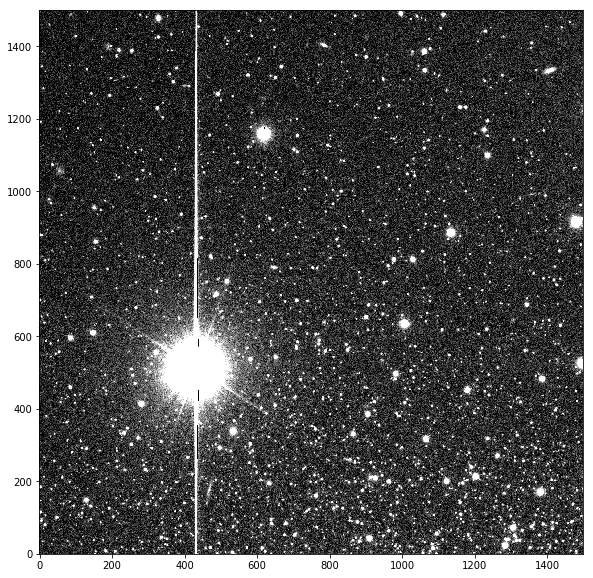

In [6]:
showfits('iM15n5trim.fits')

### pythonスクリプトを作成

さて、notebookから飛び出して、pythonスクリプトを作成しましょう。  
pythonスクリプトを作成するのは難しいことではありません。  
テキストエディタで、セルに書き込んでいた内容を下記ならべ、拡張子が.py のファイルとして保存すればよいのです。  
さらに、unix/linux系ではファイル冒頭に  
\#!/usr/local/bin/python3.5   
のようにpythonのpathを書き込むのが一般的です。  

In [7]:
import numpy as np

data1 = np.array([0, 1, 2])
data2 = np.array([[0, 0, 0], [10, 10, 10], [20, 20, 20], [30, 30, 30]])

data3 = data2 + data1 

print(data3)

[[ 0  1  2]
 [10 11 12]
 [20 21 22]
 [30 31 32]]


これを、mycode.pyというファイルに書き込みましょう。  

なんでもお好みのテキストエディタを使ってください。あるいは、jupyter notebookにはテキストエディタ機能もあります。  
jupyter notebook起動画面の右上のNew > Text File を選ぶと新規テキストファイルの画面になります。  

そのうえで、(chmod +x してから)コマンドラインで実行します。あるいは下のようにcellからも実行できます。

In [8]:
%run mycode.py

[[ 0  1  2]
 [10 11 12]
 [20 21 22]
 [30 31 32]]


### コマンドライン引数  

スクリプトに書き出したのであれば、コマンドライン引数も使いたくなります。


In [9]:
targetfits = 'iM15n5trim.fits'

In [10]:
from astropy.io import fits
import numpy as np

data = fits.getdata(targetfits)
med = np.median(data)
std = np.std(data)

for i in range(5):
    xx = np.where((data > med - 3 * std) & (data < med + 3 * std))
    med = np.median(data[xx])
    std = np.std(data[xx])
    print ('{:.2f} {:.2f}'.format(med, std))  


4077.01 227.99
4076.42 75.60
4075.29 53.93
4074.60 50.19
4074.40 49.36


ここで、targetfitsをコマンドライン引数として読み込めれば、いろんなFITSファイルに対してこのプログラムが使えます。  

コマンドライン引数を取り込むには
``` python 
import sys 
sys.argv 
``` 
を使います。  
コマンドラインに入力された文字列が空白で区切られて、リスト sys.argv に格納されます。  
sys.argv[0] はプログラム名そのものです。1番目の引数はsys.argv[1]です。 

In [11]:
cat getbackground.py

import sys
import numpy as np
from astropy.io import fits

data = fits.getdata(sys.argv[1])
med = np.median(data)
std = np.std(data)

for i in range(5):
    xx = np.where((data > med - 3 * std) & (data < med + 3 * std))
    med = np.median(data[xx])
    std = np.std(data[xx])
    print ('{:.2f} {:.2f}'.format(med, std))  
    

In [12]:
%run getbackground.py iM15n5trim.fits

4077.01 227.99
4076.42 75.60
4075.29 53.93
4074.60 50.19
4074.40 49.36


### モジュール作成  

よく使う処理を、notebookの中で関数として定義して使用するのは楽チンなのですが、  
notebookファイルを作成するたびに、前のnotebookからコピペして使うのはちょっと面倒ですね。  

頻繁に使う自作の関数はモジュールにしておきましょう。  

/home/nakajima/mypylib/mymodule.py のようなファイルを作成します。  
必要なモジュールを冒頭でimportしておき、あとは自前の関数をどんどん書き込んでいけばよいです。  
そして、他のプログラムから使うときには、   

``` python 
import sys
sys.path.append('/home/nakajima/mypylib/') 
```
として、pathを通しておき、

```python 
import mymodule
``` 
を宣言します。 mymodule.pyの.pyはimportで呼ぶときには不要です。

ここでは、このディレクトリの中に'mypylib'というディレクトリを作成し、その中にmymodule.pyを作りました。  

In [13]:
cat mypylib/mymodule.py

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt 

def getbackground(infits):
    
    data = fits.getdata(infits)
    med = np.median(data)
    std = np.std(data)
    
    for i in range(5):
        xx = np.where((data > med - 3 * std) & (data < med + 3 * std))
        med = np.median(data[xx])
        std = np.std(data[xx])
   
    return med, std


def showfits(infits):
    
    med, std = getbackground(infits)
    imdata = fits.getdata(infits)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(imdata, plt.cm.gray, vmin=med - std, vmax = med + 5 * std, origin='lower', interpolation='none')
    plt.show()


次々とこの続きに、自分の関数を書き込んでいけばよいです。

In [14]:
import sys 
sys.path.append('./mypylib/')

In [15]:
import mymodule

In [16]:
med, std = mymodule.getbackground('iM15n5trim.fits')
print(med, std)

4074.4 49.3618
